In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

import time
import ipdb
from IPython import display

%matplotlib inline

# Load data, Chicago road network
Source: [https://tzin.bgu.ac.il/~bargera/tntp/](https://tzin.bgu.ac.il/~bargera/tntp/)

In [68]:
nodes_org = pd.read_csv('./data/Chicago/node.csv')
nodes_org['x'] = (nodes_org['x'] - nodes_org['x'].min()) * 0.0003048
nodes_org['y'] = (nodes_org['y'] - nodes_org['y'].min()) * 0.0003048

edges_org = pd.read_csv('./data/Chicago/edge.csv')
    

## Zoom in the map

In [95]:
def filter_map(nodes, edges, x_min, x_max):
    y_min, y_max = x_min, x_max
    nodes = nodes.loc[(nodes['x']>x_min) & (nodes['x']<x_max)]
    nodes = nodes.loc[(nodes['y']>y_min) & (nodes['y']<y_max)]
    nodes.index = range(nodes.shape[0])
    
    new_edges = pd.DataFrame([], columns=edges.columns)
    node_list = list(nodes['NodeName'])
    for i in edges.index:
        if edges.loc[i, 'from'] in node_list and edges.loc[i, 'to'] in node_list:
            new_edges.loc[i] = edges.loc[i]
    new_edges.index = range(new_edges.shape[0])
    
    new_nodes = pd.DataFrame([], columns=nodes.columns)
    for i in nodes.index:
        if nodes.loc[i, 'NodeName'] in list(new_edges['from']) or nodes.loc[i, 'NodeName'] in list(new_edges['to']):
            new_nodes.loc[i] = nodes.loc[i]
    new_nodes.index = range(new_nodes.shape[0])
    
    return new_nodes, new_edges

In [96]:
nodes, edges = filter_map(nodes_org, edges_org, 97, 107)
nodes['x'] = nodes['x'] - nodes['x'].min()
nodes['y'] = nodes['y'] - nodes['y'].min()

In [97]:
edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.linalg.norm(from_node[['x', 'y']].values.flatten() - to_node[['x', 'y']].values.flatten())

## Treat the map as a weighted graph
Distance is the link weight

In [98]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

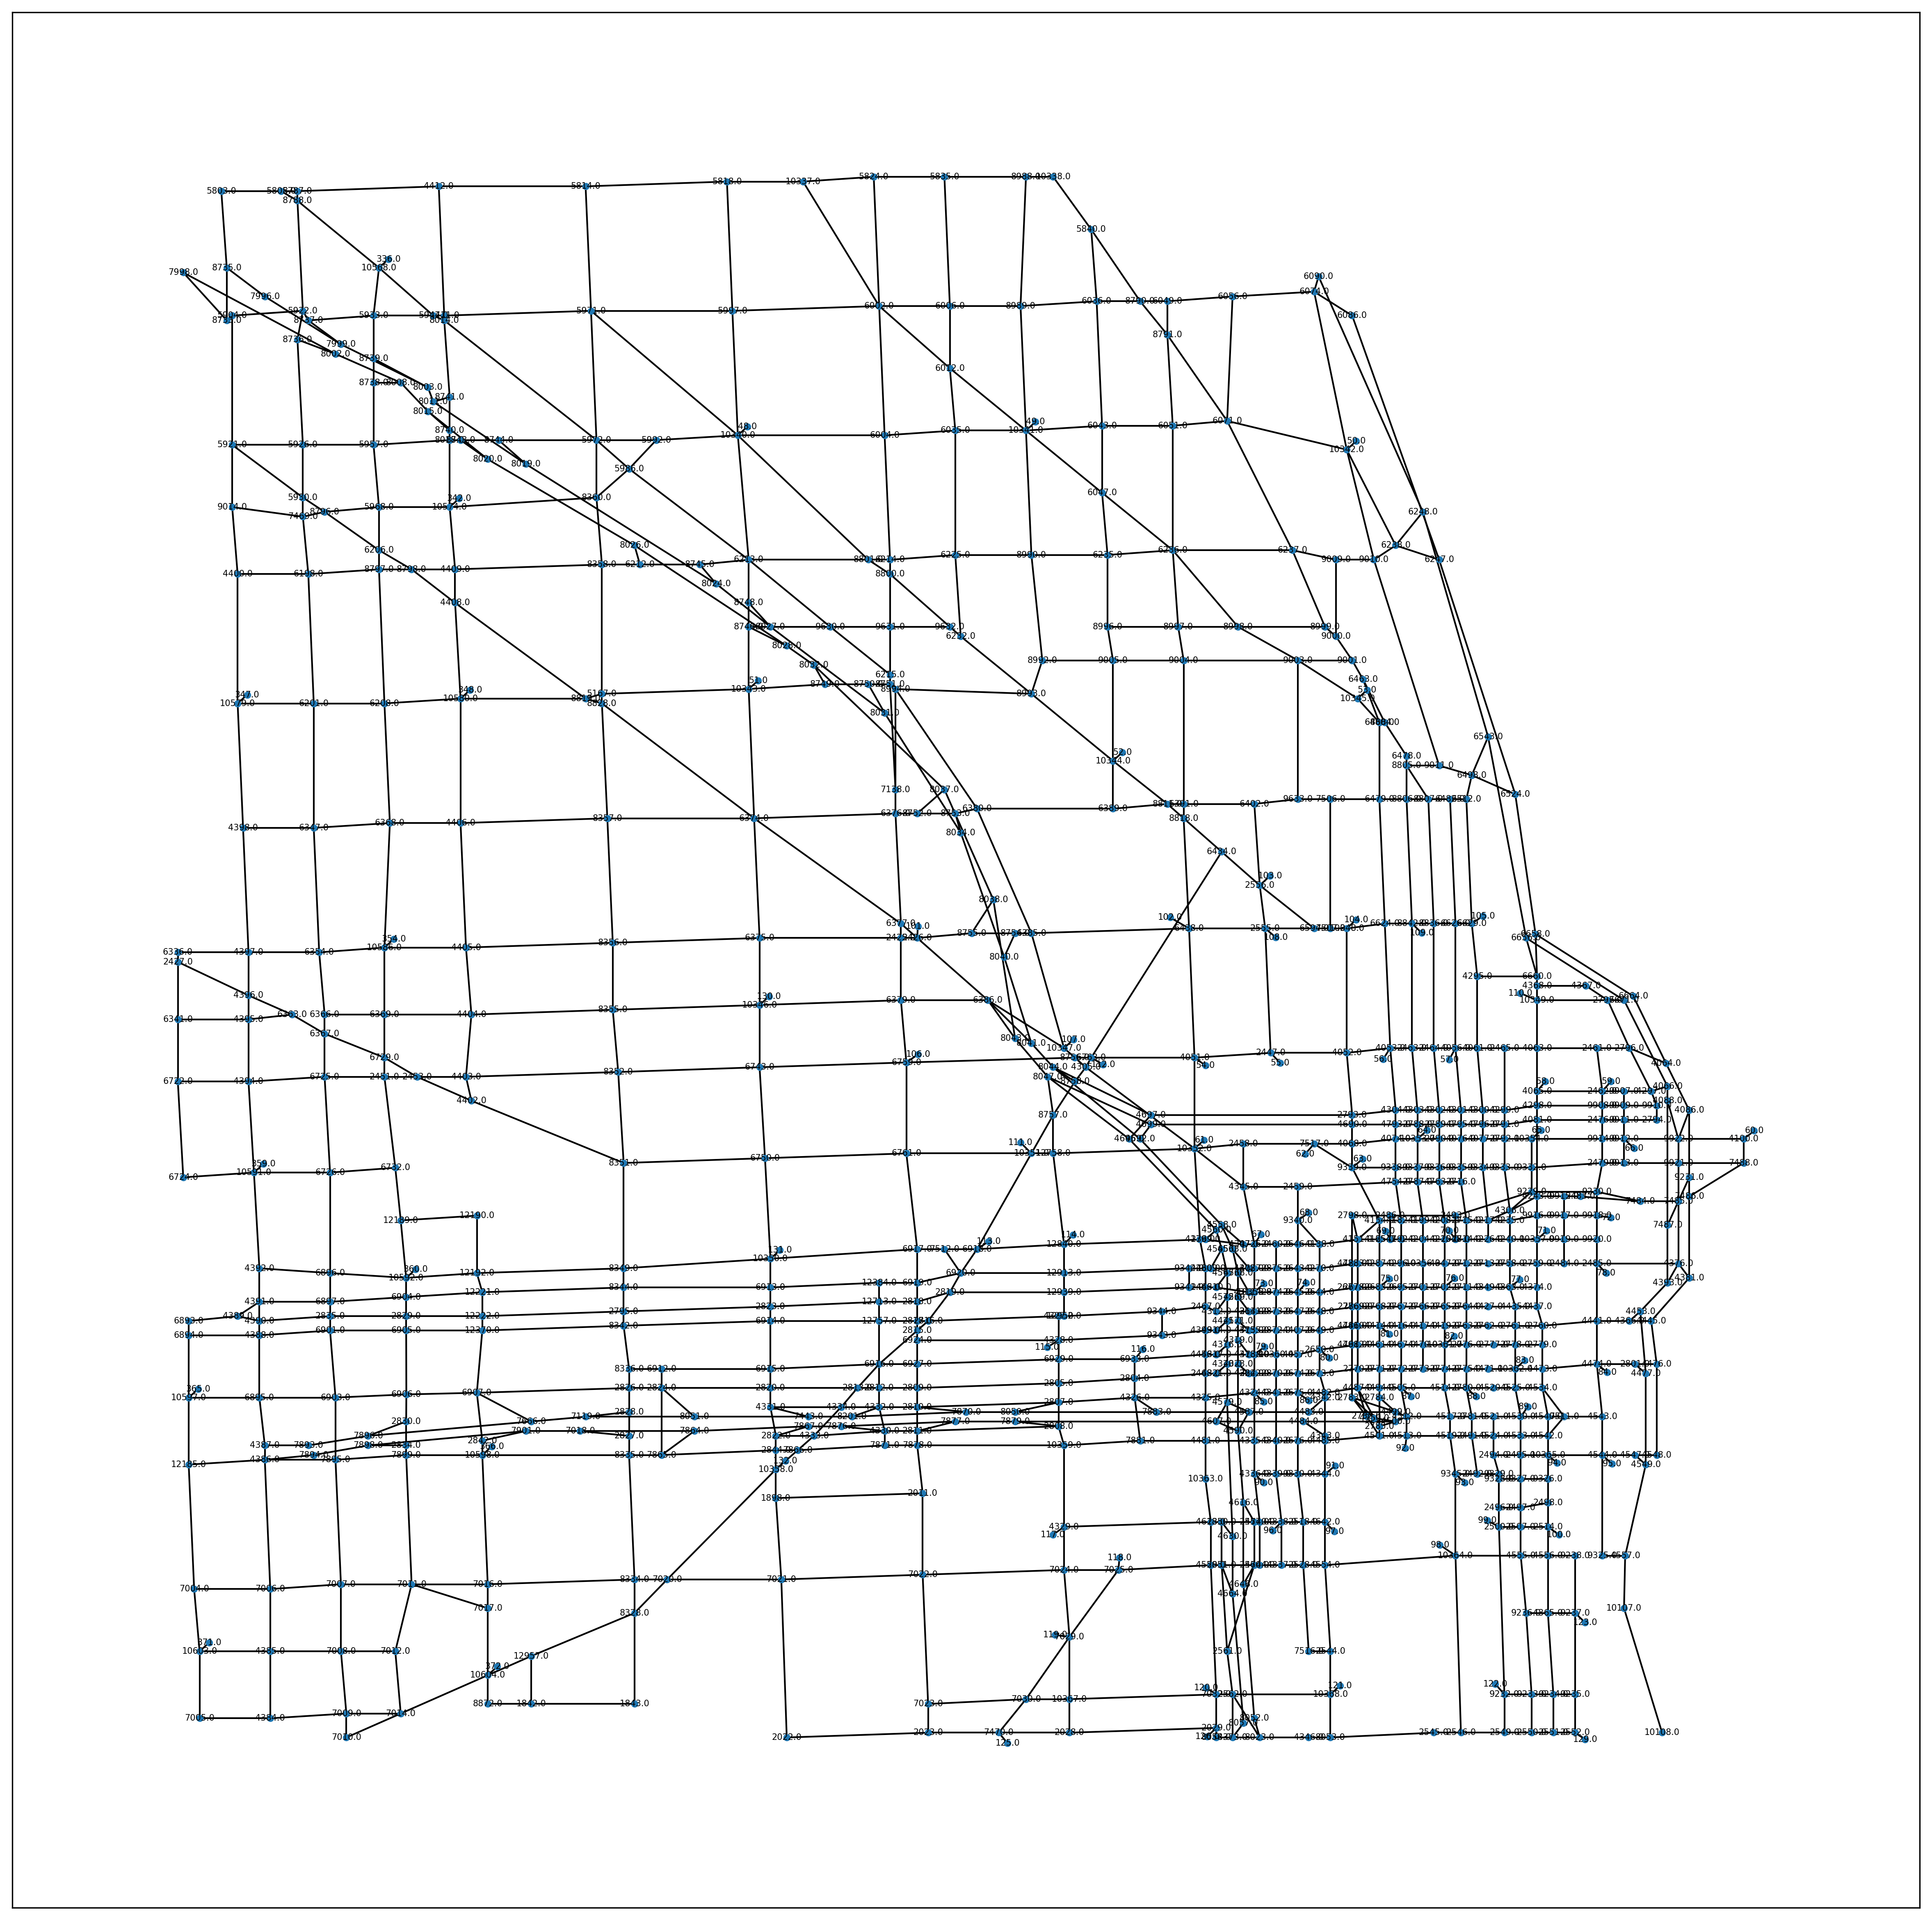

In [99]:
plt.figure(figsize=[20,20], dpi=300)
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos, font_size=5, node_size=10)

Try Dijkstra method

In [100]:
edges.loc[(edges['from']==5933) | (edges['to']==5933)]

EdgeName   from     to  distance
1233     14757   5933   5947   0.33528
1234     14758   5933   8737  0.367028
1235     14759   5933   8739   0.27432
1236     14760   5933  10568   0.30632
1238     14809   5947   5933   0.33528
1943     23581   8737   5933  0.367028
1947     23585   8739   5933   0.27432
2433     29404  10568   5933   0.30632

In [101]:
nx.dijkstra_path(G, 5933, 79)

[5933,
 8739,
 8003,
 8011,
 8019,
 8024,
 8027,
 8031,
 8034,
 8040,
 8041,
 8044,
 4692,
 4558,
 4563,
 4568,
 4311,
 10355,
 2641,
 4735,
 4738,
 79]

# Define rider

In [102]:
# some useful utility functions
def get_edge(G, from_node, to_node):
    edge = edges.loc[(edges['from']==from_node)&(edges['to']==to_node)]
    return edge['EdgeName'].iloc[0]

def norm_vec(a):
    return (np.array(a) / np.linalg.norm(np.array(a))).flatten()



def get_adj_node_position(position):
    # return the position of the closest adjacent node
    adj_node_index = (((nodes.iloc[:, 1:] - position )**2).sum(axis=1)).idxmin()
    adj_node = nodes.loc[adj_node_index, 'NodeName']
    adj_node_position = nodes.loc[nodes['NodeName']==adj_node, ['x', 'y']].to_numpy().flatten()
    return adj_node, adj_node_position

## Rider attributes

|Attributes|Type|Note|
|---|---|---|
|ID|int|specified, unchanged|
|position|1D array|updated on every move|
|state|string|'idle', 'working' or 'stop'|
|speed|int|maxspeed when working, half maxspeed when idle|
|maxspeed|int|specified, unchanged|
|stop_time|float|0 when moving, increase when stop|
|total_time|float|count from matched (start working)|
|total_time_rec|list|record of total_time|
|next_node|int|determined by path or randomly chosen|
|nextnext_node|int|determined by path or randomly chosen|
|destination|int|can be merchant_node or customer_node, is None when idle|
|path|list|obtained by dijkstra method, is None when idle|
|merchant_node|int|obtained from knowledge|
|customer_nodes|list|obtained from knowledge, updated on every arrival of destinations|
|matched_orders|list|updated on every arrival of destinations|
|if_matched|boolean|if the rider is matched, randomly chosen by the platform|
|if_matchable|boolean|if the rider lies in the matching area, it is matchable|
|dec_var|dict|contains r cR k t N q_bar|
|initial_knowledge|dict|contains map merchant_node customer_nodes, unchanged|
|knowledge|dict|contains map merchant_node customer_nodes|


## Rider movements


In [219]:
class rider:
    def __init__(self, config, dec_var, knowledge):
        # config is a dictionary
        self.ID = config['ID']                                  # scalar
        self.position = config['initial_position']              # 2-D array
        self.maxspeed = config['maxspeed']                      # scalar
        self.stop_time = 0                                      # scalar, float
        self.state = 'idle'                                     # string 'idle' or 'working' or 'stop'
        self.speed = self.maxspeed / 2
        self.if_matched = False
        self.customer_nodes = []
        self.matched_orders = []
        self.path = None
        self.destination = None
        self.total_time = 0
        self.total_time_rec = []
        self.if_matchable = False
        
        self.dec_var = dec_var  # decition variables
        
        adj_node, adj_node_position = get_adj_node_position(self.position)
        if np.linalg.norm(adj_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(adj_node_position - self.position)
        
        self.next_node = adj_node
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])

        # give initial knowledge
        self.initial_knowledge = knowledge.copy()
        self.knowledge = knowledge
        self.merchant_node = knowledge['merchant_node']

    def update_knowledge(self):
        self.merchant_node = self.knowledge['merchant_node']     # scalar
        self.customer_nodes = self.knowledge['customer_nodes']   # 1-D array
        self.destination = self.merchant_node if self.state!='idle' else None
        
        adj_node, adj_node_position = get_adj_node_position(self.position)
        if np.linalg.norm(adj_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(adj_node_position - self.position)
        
        self.next_node = adj_node
        # first go to the closest node, then follow the path

        self.path = nx.dijkstra_path(
            self.knowledge['map'], self.next_node, self.destination
        ) if self.state!='idle' else None
        # next node is the last node, then the next next node is random
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)]) if self.next_node==self.path[-1] else self.path[1]

        # when matched or initialization, set it to be unmatchable
        self.if_matchable = False
    
    def check_distance_2_merchant(self):
        merchant_position = nodes.loc[nodes['NodeName']==self.merchant_node, ['x', 'y']].to_numpy().flatten()
        if np.linalg.norm(self.position - merchant_position) <= self.dec_var['r']:
            self.if_matchable = True
        else:
            self.if_matchable = False

    def move(self, t_resolution, dec_var):
        self.dec_var = dec_var
        # move one step foward
        if self.state == 'idle':
            travel_distance_mag = self.speed * np.random.rand() * t_resolution
            if self.if_matched:
                self.state = 'working'
                self.speed = self.maxspeed
                self.update_knowledge()
                
        elif self.state == 'working':
            travel_distance_mag = self.speed * t_resolution
            self.total_time += t_resolution
        elif self.state == 'stop':
            self.total_time += t_resolution
            self.stop(t_resolution)
            self.check_distance_2_merchant()
            return
        
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        distance_to_next_node = np.linalg.norm(self.position - next_node_position)
        
        if travel_distance_mag < distance_to_next_node:
            self.position = self.position + travel_distance_mag * self.direction
        elif travel_distance_mag >= distance_to_next_node:
            # travel distance greater than the distance to the next node
            self.position = next_node_position
            
            if self.state=='working' and self.next_node == self.destination:  # this is for working riders
                # arrive the destination
                # give up the abundant distance, and stop
                self.stop(t_resolution)
                self.check_distance_2_merchant()
                return
                
            exceed_distance = travel_distance_mag - distance_to_next_node
            
            nextnext_node_position = nodes.loc[nodes['NodeName']==self.nextnext_node, ['x', 'y']].to_numpy().flatten()
            self.direction = norm_vec(nextnext_node_position - next_node_position)
            
            self.position = self.position + exceed_distance * self.direction
            self.next_node = self.nextnext_node
            
            if self.state=='idle':
                self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
            else:
                if self.next_node == self.destination:
                    # next node is the last node, then the next next node is random
                    self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
                else:
                    self.nextnext_node = self.path[self.path.index(self.next_node) + 1]
        self.check_distance_2_merchant()

    def stop(self, t_resolution):
        # when pickup, delivered, or else
        self.state = 'stop'
        if self.stop_time > 0.1:
            # restart
            self.state = 'working'
            self.stop_time = 0
            # update
            next_destination = self.get_closest_node(self.position)
            if next_destination==None:
                # complete
                self.complete()
                return
            next_dest_i = self.customer_nodes.index(next_destination)
            new_customer_nodes = []
            new_customer_nodes.extend(self.customer_nodes[:next_dest_i])
            new_customer_nodes.extend(self.customer_nodes[next_dest_i+1:])
            self.customer_nodes = new_customer_nodes
            self.matched_orders.append(next_destination)
            self.update(next_destination, t_resolution)
        else:
            self.stop_time = self.stop_time + t_resolution
    
    def complete(self):
        # complete all orders in current bundle
        print('rider %i completed! time:%.2f'%(self.ID, self.total_time))
        self.next_node = np.random.choice([i for i in G.neighbors(self.next_node)])
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
        
        self.state = 'idle'
        self.speed = self.maxspeed / 2
        self.knowledge = self.initial_knowledge
        self.if_matched = False
        self.customer_nodes = []
        self.matched_orders = []
        self.path = None
        self.destination = None
        self.total_time_rec.append(self.total_time)
        self.total_time = 0
        return
    
    def update(self, destination, t_resolution):
        # after arriving one destination
        self.destination = destination
        self.path = nx.dijkstra_path(self.knowledge['map'], self.next_node, self.destination)  # next_node is current location
        if len(self.path)==1:
            self.stop(t_resolution)
            return
        self.next_node = self.path[1]
        # if only 2 nodes, then nextnext node is random
        self.nextnext_node = self.path[2] if len(self.path)>2 else np.random.choice([i for i in G.neighbors(self.next_node)])  
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
        
    def get_closest_node(self, from_node):
        # by distance traveled, dijkstra distance
        # from_node: ID or position
        if type(from_node)==int:
            None
        elif type(from_node)==np.ndarray:
            current_node = int(
                nodes.loc[(nodes['x']==from_node[0])&(nodes['y']==from_node[1]), 'NodeName'].values
            )
            from_node = current_node

        distance = 1e10
        closest_node = None
        for i in self.customer_nodes:
            if nx.dijkstra_path_length(self.knowledge['map'], from_node, i) < distance:
                distance = nx.dijkstra_path_length(self.knowledge['map'], from_node, i)
                closest_node = i
        return closest_node

# Define platform


In [220]:
class platform:
    def __init__(self, r, cR, k, t_resolution):
        self.accumulated_order = []
        self.r = r
        self.cR = cR
        self.k = k
        self.t_resolution = t_resolution
    
    def acquire_order(self, q):
        q_t_resolution = q * self.t_resolution
        num_generated_order = np.random.randint(2 * q_t_resolution)
        self.accumulated_order.extend(list(np.random.choice(list(nodes['NodeName']), size=num_generated_order, replace=False)))
    
    def remove_order(self, matched_batches):
        for i in matched_batches.flatten():
            self.accumulated_order.remove(i)
    
    def match(self, idle_rider_IDs):
        n_idle_riders = len(idle_rider_IDs)

        num_required_riders = min(len(idle_rider_IDs), len(self.accumulated_order)//self.k)
        matched_rider_IDs = np.random.choice(idle_rider_IDs, num_required_riders, replace=False)
        
        matched_batches = []
        for i in range(len(matched_rider_IDs)):
            matched_batches.append(np.array(self.accumulated_order)[self.k*i:self.k*(i+1)])
        matched_batches = np.array(matched_batches)
        
        self.remove_order(matched_batches)
        
        self.matched_batches = matched_batches

        return matched_batches, list(matched_rider_IDs)
        

In [221]:
## Multi processing, but it is slower if only step one pace forward

# import multiprocessing
# from multiprocessing import Pool

# def move_all_riders(N, matched_rider_IDs, matched_batches):
#     n_cpu = multiprocessing.cpu_count()
#     pool = Pool(processes=n_cpu)
    
#     # number of riders at each process
#     N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
#     n_process = n_cpu if N%N_each_process != 0 else n_cpu - 1
    
#     params = []
#     for i in range(n_process):
#         params.append(
#             [
#                 rider_set[i*N_each_process:(i+1)*N_each_process],
#                 knowledge_set[i*N_each_process:(i+1)*N_each_process],
#                 t_resolution,
#                 matched_rider_IDs,
#                 matched_batches
#             ]
#         )

#     moved_rider_set = pool.starmap(func=rider.move_rider, iterable=params )
#     return moved_rider_set

In [271]:
config_set = []
rider_set = []
# knowledge_set = []
N = 600
q_bar = 1000
r = 5
cR = 5
k = 3
t_resolution = 0.005

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t_resolution,
    'N': N,
    'q_bar': q_bar
}


In [272]:
for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.rand()*nodes['x'].max(), np.random.rand()*nodes['y'].max()]),
        'maxspeed': np.random.randint(10, 20)
    }
    knowledge_i = {
        'map': G,
        'merchant_node': 6759,
        'customer_nodes': []
    }
    rider_i = rider(config_i, dec_var, knowledge_i)

    
    config_set.append(config_i)
    rider_set.append(rider_i)
#     knowledge_set.append(knowledge_i)
    

In [273]:
plat = platform(r, cR, k, t_resolution)

In [274]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []

In [275]:
def move_rider(rider_set, t_resolution, matched_rider_IDs, matched_batches):
    for i in range(len(rider_set)):
        rider_i = rider_set[i]
        if rider_i.ID in matched_rider_IDs:
            # if this rider is mathced, update if_matched
            rider_i.if_matched = True
            # find corresponding index of rider in matched_rider_IDs
            batch_index = matched_rider_IDs.index(rider_i.ID)
            # get the corresponding matched batch and update to knowledge
            rider_i.knowledge['customer_nodes'] = list(matched_batches[batch_index, :])
            # move rider with knowledge
            rider_i.move(t_resolution, dec_var)
        else:
            rider_i.move(t_resolution, dec_var)
    
    return rider_set


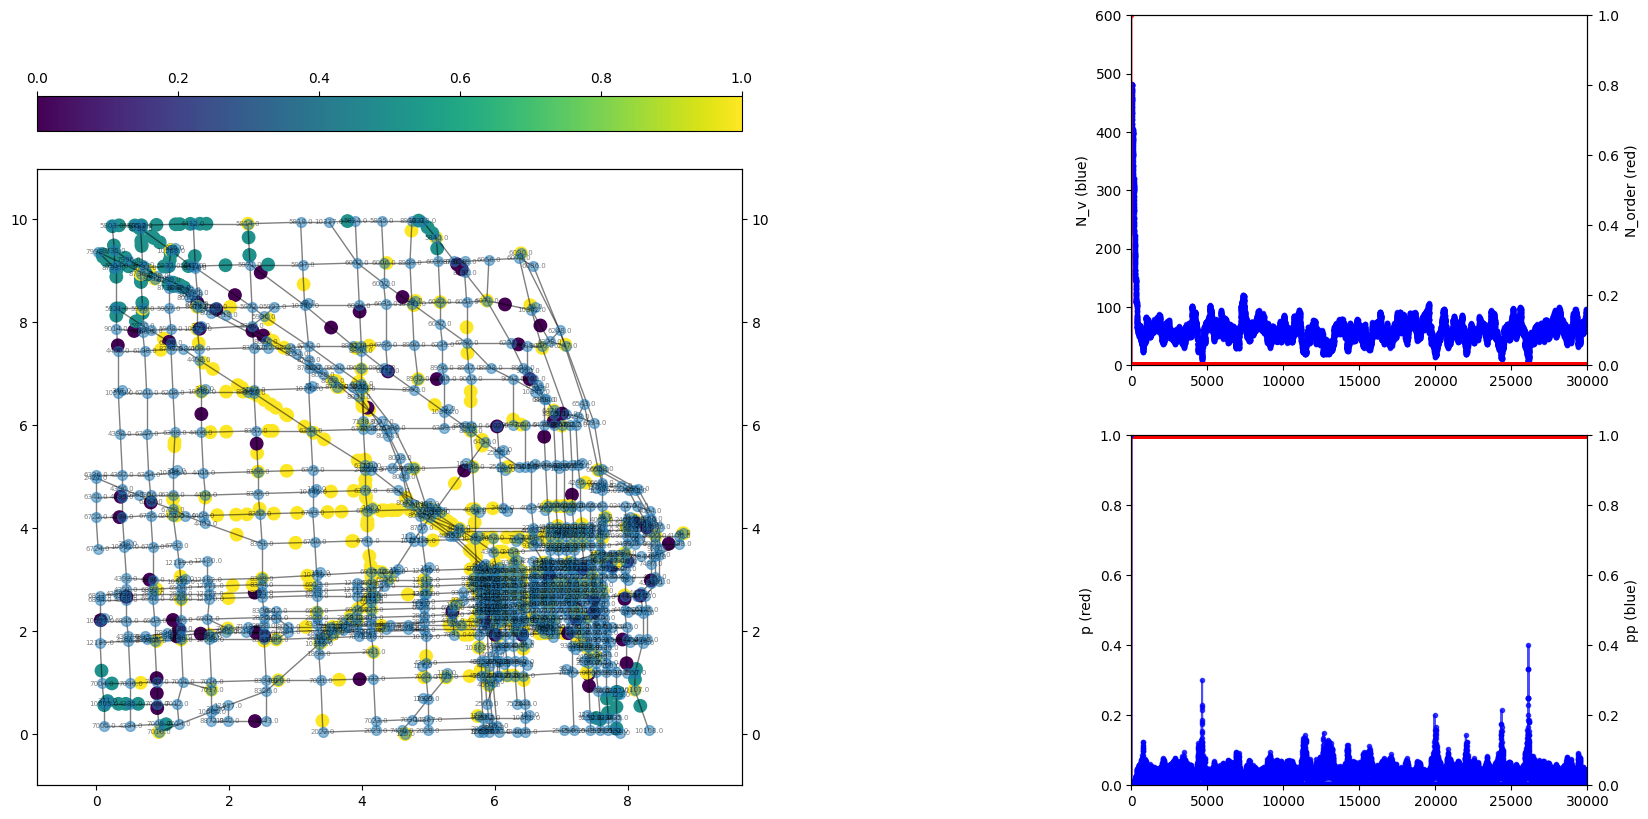

rider 13 completed! time:2.13 True working
rider 293 completed! time:2.34 True working
rider 489 completed! time:1.10 True working
rider 596 completed! time:1.66 True working
rider 149 completed! time:1.71 True working
rider 322 completed! time:1.85 True working
rider 349 completed! time:1.56 True working
rider 350 completed! time:2.31 True working
rider 23 completed! time:1.49 True working
rider 448 completed! time:1.93 True working
rider 176 completed! time:1.12 True working
rider 440 completed! time:1.80 True working
rider 78 completed! time:1.26 True working
rider 419 completed! time:1.41 True working
rider 169 completed! time:1.60 True working
rider 101 completed! time:1.34 True working
rider 115 completed! time:1.45 True working
rider 355 completed! time:1.48 True working
rider 554 completed! time:1.41 True working
rider 294 completed! time:1.61 True working
rider 432 completed! time:1.68 True working
rider 45 completed! time:1.75 True working


KeyboardInterrupt: 

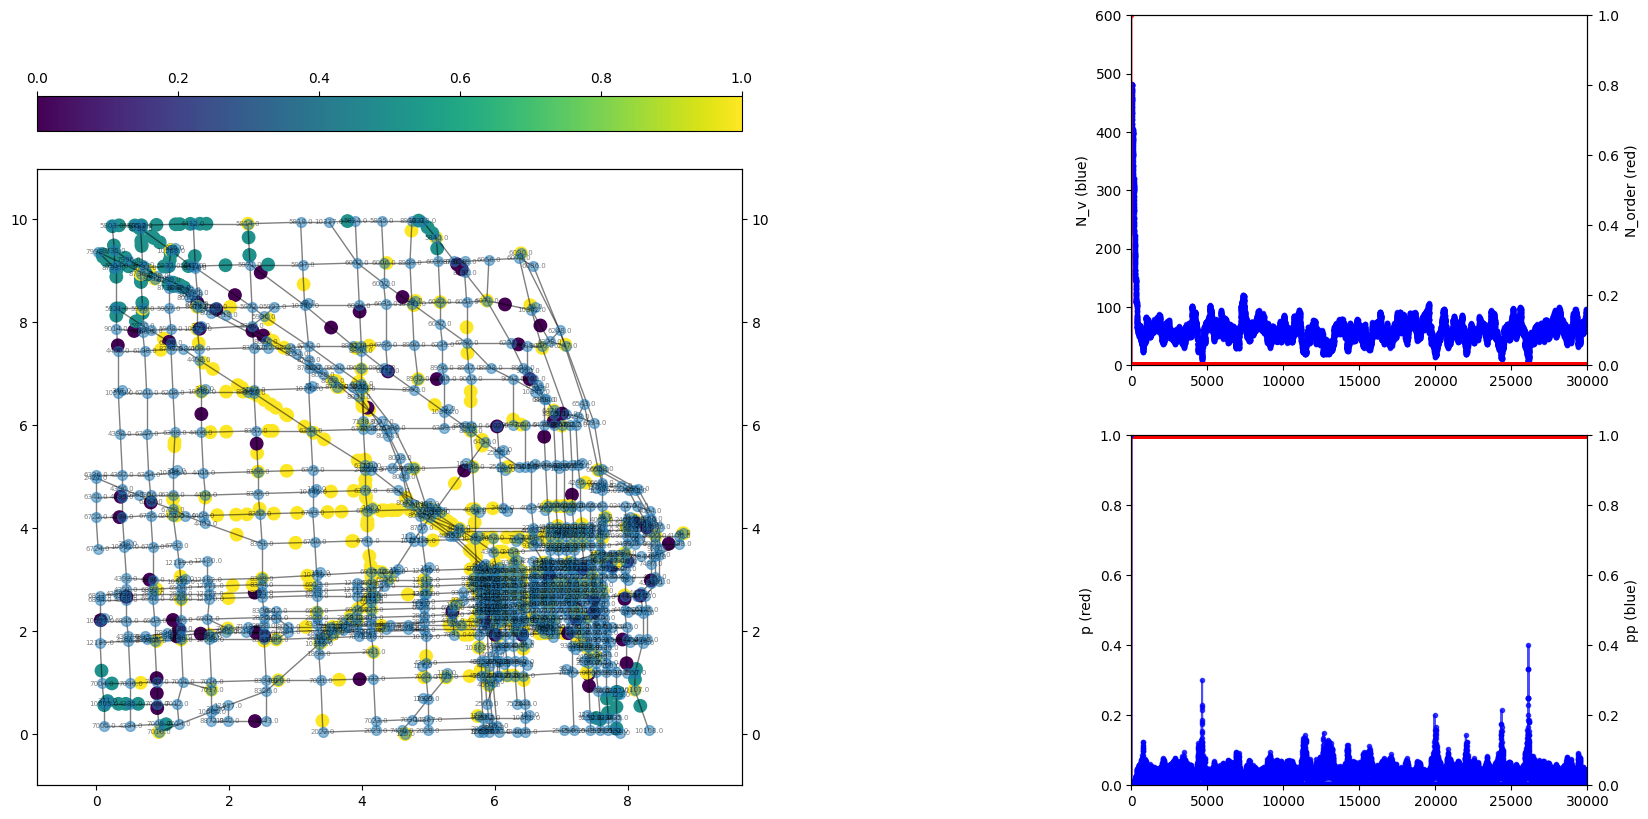

In [276]:
# marking the x-axis and y-axis
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)
ax0 = ax.twinx()
ax0.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax0.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)

ax2 = fig.add_subplot(233)
ax2.set_ylabel('N_v (blue)')
ax3 = ax2.twinx()
ax3.set_ylabel('N_order (red)')
ax4 = fig.add_subplot(236)
ax4.set_ylabel('p (red)')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_ylim([0, 1])

# plt.tight_layout()

nx.draw_networkx(G, pos=pos, ax=ax0, node_size=50, font_size=5, alpha=0.5)

color = np.ones(N) * 0.5
scat = ax.scatter(np.random.randint(6, size=N), np.random.randint(6, size=N), s=80, c=color, vmin=0, vmax=1)
fig.colorbar(scat, ax=ax, location='top')
line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)


while c < 100000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    plat.acquire_order(q_bar)
    matched_batches, matched_rider_IDs = plat.match(idle_rider_IDs)
    
    num_matched_cust = matched_batches.size
    try:
        p = num_matched_cust / (num_matched_cust + len(plat.accumulated_order)//k)
    except:
        # when there is no order
        p = 1
    try:
        pp = len(matched_rider_IDs) / len(idle_rider_IDs)
    except:
        pp = 1
    
    # move
    rider_set = move_rider(rider_set, t_resolution, matched_rider_IDs, matched_batches)
#     moved_rider_set = move_all_riders(N, matched_rider_IDs, matched_batches)
#     moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
#     rider_set = moved_rider_set
    
    
    
    x_axis.append(c)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(len(plat.accumulated_order)//k)
    p_set.append(p)
    pp_set.append(pp)
    
    if c%20==0:
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        ax4.set_ylim([0, 1])
        line5.set_data(x_axis, pp_set)
        ax5.set_ylim([0, 1])

        ax2.set_xlim([0, c])
        ax3.set_xlim([0, c])
        ax4.set_xlim([0, c])
        ax5.set_xlim([0, c])

        display.clear_output(wait=True)
        display.display(plt.gcf()) 
    
    #### print area
#     print('next node', rider_set[0].next_node)
#     print('nextnext node', rider_set[0].nextnext_node)
#     print('destination', rider_set[0].destination)
#     print('state', rider_set[0].state)
#     print('customers', rider_set[0].customer_nodes)
#     print('matched orders', rider_set[0].matched_orders)
    
#     print('\n')
    
#     print('matched riders', matched_rider_IDs)
#     print(color)
#     print([i.state for i in rider_set])
#     print([i.if_matchable for i in rider_set])
    ####

    c += 1
    

In [269]:
for i in range(N):
    print(rider_set[i].ID, rider_set[i].customer_nodes, rider_set[i].knowledge['customer_nodes'], rider_set[i].state, rider_set[i].if_matched)

0 [] [] idle False
1 [] [] idle False
2 [] [] idle False
3 [] [] idle False
4 [] [] idle False
5 [] [] idle False
6 [] [] idle False
7 [] [] idle False
8 [] [] idle False
9 [] [] idle False
10 [] [] idle False
11 [] [] idle False
12 [] [] idle False
13 [] [] idle False
14 [] [] idle False
15 [] [] idle False
16 [] [] idle False
17 [4387.0, 7023.0, 342.0] [4387.0, 7023.0, 342.0] working True
18 [] [] idle False
19 [] [] idle False
20 [] [] idle False
21 [] [] idle False
22 [] [] idle False
23 [] [] idle False
24 [] [] idle False
25 [] [] idle False
26 [] [] idle False
27 [] [] idle False
28 [] [] idle False
29 [] [] idle False
30 [] [] idle False
31 [] [] idle False
32 [] [] idle False
33 [] [] idle False
34 [] [] idle False
35 [] [] idle False
36 [] [] idle False
37 [] [] idle False
38 [] [] idle False
39 [] [] idle False
40 [] [] idle False
41 [] [] idle False
42 [] [] idle False
43 [8801.0, 8015.0, 9001.0] [8801.0, 8015.0, 9001.0] working True
44 [] [] idle False
45 [] [] idle False
